# diag_btrop_flux

Investigate barotropic flux divergence: trying to understand why it is positive over the entire domain

Compare simulation with and without tidal potential. Tidal potential should not be a problem (on the contrary, it is better to add it in larger domains), but the problem might come from the shift in TPXO7.

cf. also [diag_btrop_fluxeb.ipynb]

In [1]:
%matplotlib inline
import sys, os, time
from netCDF4 import Dataset, MFDataset

import numpy as np
from matplotlib import pyplot as plt

import scipy.signal as sig
import scipy.ndimage as ndi

In [2]:
# general parameters (although they might be overwritten in some cells)

krypton = "/data0/project/vortex/lahaye/"
picdir = "pictures/diag_btrop_fluxes/"
dosavefig = True

Ntmax = 180
Ntmin = 0
nst = 1

slit = slice(Ntmin, Ntmax, nst)

In [71]:
simul = "luckyto-beg"
path_fluxbt = krypton+"DIAG/NRJ_fluxes/{}_bt_fluxes.?.nc".format(simul)
path_fluxbc = krypton+"DIAG/NRJ_fluxes/{}_bclnrj.?.nc".format(simul)

nc = MFDataset(path_fluxbt, aggdim="eta_rho")
ekbt = np.nanmean(nc.variables['ek_bt'][:,:,slit] + nc.variables['ep_bt'][:,:,slit], axis=(0,1))*1e3 
pu = nc.variables['pu_bt'][:,:,slit]*1e3
pv = nc.variables['pv_bt'][:,:,slit]*1e3
nc.close()
dxm, dym = 748.26*2, 748.27*2

Ny, Nx, Nt = pu.shape
outfbt = (np.nansum(pu[:,-1,:] - pu[:,0,:], axis=0)/dxm \
          + np.nansum(pv[-1,:,:] - pv[0,:,:], axis=0)/dym) * 1e3/Nx/Ny
divfbt = np.gradient(pu, dxm, axis=1) + np.gradient(pv, dym, axis=0)
del pu, pv

nc = MFDataset(path_fluxbc, aggdim="eta_rho")
ekbc = np.nanmean(nc.variables['ekint'][:,:,slit] + nc.variables['epint'][:,:,slit], axis=(0,1))*1e3 
pu = nc.variables['puint'][:,:,slit]*1e3
pv = nc.variables['pvint'][:,:,slit]*1e3
nc.close()

outfbc = (np.nansum(pu[:,-1,:] - pu[:,0,:], axis=0)/dxm \
          + np.nansum(pv[-1,:,:] - pv[0,:,:], axis=0)/dym)*1e3/Nx/Ny
divfbc = np.gradient(pu, dxm, axis=1) + np.gradient(pv, dym, axis=0)
del pu, pv

dt = 1.*nst

times = np.arange(Nt)*dt

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


MemoryError: 

In [ ]:
fcut = 2*dt/16

bb, aa = sig.butter(4, fcut, btype="low")

divfilt = sig.filtfilt(bb, aa, np.nanmean(divfbt, axis=(0,1)), method="gust")*1e3
#divbilt = np.zeros(Nt)
#for iy in range(Ny):
#    divbilt += np.nansum(sig.filtfilt(bb, aa, divfbt[iy,:,:], axis=-1, method="gust"), axis=0)/Nx
    
plt.plot(times, np.nanmean(divfbt,axis=(0,1))*1e3)
plt.plot(times, divfilt)
#plt.plot(times, divbilt, '--')
plt.plot(times, outfbt, '--')

divfilc = sig.filtfilt(bb, aa, np.nanmean(divfbc, axis=(0,1)), method="gust")*1e3
#divbilt = np.zeros(Nt)
#for iy in range(Ny):
#    divbilt += np.nansum(sig.filtfilt(bb, aa, divfbc[iy,:,:], axis=-1, method="gust"), axis=0)/Nx

plt.plot(times, np.nanmean(divfbc,axis=(0,1))*1e3)
plt.plot(times, divfilc, '--')
#plt.plot(times, divbilt, '--')
plt.plot(times, outfbc, '--')

plt.ylim(np.array([-1,1])*5)
plt.grid(True)

In [ ]:
### Rebuild barotropic fluxes: LUCKYM2, established

grav = 9.81; rho0 = 1025.
dofilt = False

path_2D = krypton+"luckym2_tseries/luckym2_tseries_2Dvars.nc"
Nt = 180
times = np.arange(Nt)/24.

nc = Dataset(path_2D, "r")
xi = nc.variables['xi_rho'][:].astype(int)
eta = nc.variables['eta_rho'][:].astype(int)
nc.close()

nc = Dataset(krypton+'lucky_corgrd.nc', "r")
topo = nc.variables['h'][eta,xi]
dxm = ( (xi[1]-xi[0]) / nc.variables['pm'][eta,:][:,xi] ).mean()
dym = ( (eta[1]-eta[0]) / nc.variables['pn'][eta,:][:,xi] ).mean()
nc.close()
Ny, Nx = topo.shape

nc = Dataset(path_2D, "r")

pb_we = nc.variables['pbar'][:,::Nx-1,:Nt]
pb_we -= np.nanmean(pb_we, axis=-1)[:,:,None]
pb_we += rho0*grav*nc.variables['zeta'][:,::Nx-1,:Nt]
ubar = nc.variables['ubar'][:,::Nx-1,:Nt]

pb_sn = nc.variables['pbar'][::Ny-1,:,:Nt]
pb_sn -= np.nanmean(pb_sn, axis=-1)[:,:,None]
pb_sn += rho0*grav*nc.variables['zeta'][::Ny-1,:,:Nt]
vbar = nc.variables['vbar'][::Ny-1,:,:Nt]
nc.close()

if dofilt:
    bm, am = sig.butter(4, 2./12.42*np.array([1/1.2,1.2]), btype="band")
    pb_we = sig.filtfilt(bm, am, pb_we, method='gust', axis=-1)
    pb_sn = sig.filtfilt(bm, am, pb_sn, method="gust", axis=-1)
    ubar = sig.filtfilt(bm, am, ubar, method="gust", axis=-1)
    vbar = sig.filtfilt(bm, am, ubar, method="gust", axis=-1)

pu = pb_we*ubar*topo[:,::Nx-1,None]
pv = pb_sn*vbar*topo[::Ny-1,:,None]
re_out = (np.nansum(np.diff(pu, axis=1).squeeze(), axis=0)/dxm \
          + np.nansum(np.diff(pv, axis=0).squeeze(), axis=0)/dym) * 1e3/Nx/Ny

# compare with what is in file
nc = MFDataset(krypton+"DIAG/NRJ_fluxes/luckym2_bt_fluxes.?.nc", aggdim="eta_rho")
pu = nc.variables['pu_bt'][:,::Nx-1,:Nt]*1e3
pv = nc.variables['pv_bt'][::Ny-1,:,:Nt]*1e3
nc.close()
outfb = (np.nansum(pu[:,-1,:] - pu[:,0,:], axis=0)/dxm \
          + np.nansum(pv[-1,:,:] - pv[0,:,:], axis=0)/dym) * 1e3/Nx/Ny

# low pass filter
bb, aa = sig.butter(4, 2./20., btype="low")

flua = sig.filtfilt(bb, aa, re_out, method="gust")
flub = sig.filtfilt(bb, aa, re_out, method="pad")
flud = sig.filtfilt(bb, aa, outfb, method="gust")

bm, am = sig.butter(4, 1.5/12.42, btype="high")
fluf = sig.filtfilt(bm, am, re_out, method="gust")
fluc = re_out - fluf

# plot it !
plt.figure()

plt.plot(times, flua)
plt.plot(times, flub,'--')
plt.plot(times, fluc, '--')
plt.plot(times, flud, '--')

plt.grid(True)

In [ ]:
### Rebuild barotropic fluxes: LUCKYM2, established

grav = 9.81; rho0 = 1025.
dofilt = False

path_2D = krypton+"prov/luckym2-beg_tseries_2Dvars.nc"
Nt = 180
times = np.arange(Nt)/24.

nc = Dataset(path_2D, "r")
xi = nc.variables['xi_rho'][:].astype(int)
eta = nc.variables['eta_rho'][:].astype(int)
nc.close()

nc = Dataset(krypton+'lucky_corgrd.nc', "r")
topo = nc.variables['h'][eta,xi]
dxm = ( (xi[1]-xi[0]) / nc.variables['pm'][eta,:][:,xi] ).mean()
dym = ( (eta[1]-eta[0]) / nc.variables['pn'][eta,:][:,xi] ).mean()
nc.close()
Ny, Nx = topo.shape

nc = Dataset(path_2D, "r")

pb_we = nc.variables['pbar'][:,::Nx-1,:Nt]
pb_we -= np.nanmean(pb_we, axis=-1)[:,:,None]
pb_we += rho0*grav*nc.variables['zeta'][:,::Nx-1,:Nt]
ubar = nc.variables['ubar'][:,::Nx-1,:Nt]

pb_sn = nc.variables['pbar'][::Ny-1,:,:Nt]
pb_sn -= np.nanmean(pb_sn, axis=-1)[:,:,None]
pb_sn += rho0*grav*nc.variables['zeta'][::Ny-1,:,:Nt]
vbar = nc.variables['vbar'][::Ny-1,:,:Nt]
nc.close()

if dofilt:
    bm, am = sig.butter(4, 2./12.42*np.array([1/1.2,1.2]), btype="band")
    pb_we = sig.filtfilt(bm, am, pb_we, method='gust', axis=-1)
    pb_sn = sig.filtfilt(bm, am, pb_sn, method="gust", axis=-1)
    ubar = sig.filtfilt(bm, am, ubar, method="gust", axis=-1)
    vbar = sig.filtfilt(bm, am, ubar, method="gust", axis=-1)

pu = pb_we*ubar*topo[:,::Nx-1,None]
pv = pb_sn*vbar*topo[::Ny-1,:,None]
re_out = (np.nansum(np.diff(pu, axis=1).squeeze(), axis=0)/dxm \
          + np.nansum(np.diff(pv, axis=0).squeeze(), axis=0)/dym) * 1e3/Nx/Ny

# compare with what is in file
nc = MFDataset(krypton+"DIAG/NRJ_fluxes/luckym2-beg_bt_fluxes.?.nc", aggdim="eta_rho")
pu = nc.variables['pu_bt'][:,::Nx-1,:Nt]*1e3
pv = nc.variables['pv_bt'][::Ny-1,:,:Nt]*1e3
nc.close()
outfb = (np.nansum(pu[:,-1,:] - pu[:,0,:], axis=0)/dxm \
          + np.nansum(pv[-1,:,:] - pv[0,:,:], axis=0)/dym) * 1e3/Nx/Ny

# low pass filter
bb, aa = sig.butter(4, 2./20., btype="low")

flua = sig.filtfilt(bb, aa, re_out, method="gust")
flub = sig.filtfilt(bb, aa, re_out, method="pad")
flud = sig.filtfilt(bb, aa, outfb, method="gust")

bm, am = sig.butter(4, 1.5/12.42, btype="high")
fluf = sig.filtfilt(bm, am, re_out, method="gust")
fluc = re_out - fluf

# plot it !
plt.figure()

plt.plot(times, flua)
plt.plot(times, flub,'--')
plt.plot(times, fluc, '--')
plt.plot(times, flud, '--')

plt.grid(True)
plt.xlabel('time (days)')
plt.ylabel('F_{bt}')
plt.title('luckym2 W/ pot: mean F_{bt} out (mW/m^2)')

if dosavefig:
    plt.savefig(picdir+"luckym2-beg_Fbt_timevol.pdf", magnification="auto"\
                , dpi=150, bbox_inches="tight")

In [ ]:
### Rebuild barotropic fluxes: LUCKYM2, established

grav = 9.81; rho0 = 1025.
dofilt = False

path_2D = krypton+"prov/luckym2-nopot_tseries_2Dvars.nc"
Nt = 180
times = np.arange(Nt)/24.

nc = Dataset(path_2D, "r")
xi = nc.variables['xi_rho'][:].astype(int)
eta = nc.variables['eta_rho'][:].astype(int)
nc.close()

nc = Dataset(krypton+'lucky_corgrd.nc', "r")
topo = nc.variables['h'][eta,xi]
dxm = ( (xi[1]-xi[0]) / nc.variables['pm'][eta,:][:,xi] ).mean()
dym = ( (eta[1]-eta[0]) / nc.variables['pn'][eta,:][:,xi] ).mean()
nc.close()
Ny, Nx = topo.shape

nc = Dataset(path_2D, "r")

pb_we = nc.variables['pbar'][:,::Nx-1,:Nt]
pb_we -= np.nanmean(pb_we, axis=-1)[:,:,None]
pb_we += rho0*grav*nc.variables['zeta'][:,::Nx-1,:Nt]
ubar = nc.variables['ubar'][:,::Nx-1,:Nt]

pb_sn = nc.variables['pbar'][::Ny-1,:,:Nt]
pb_sn -= np.nanmean(pb_sn, axis=-1)[:,:,None]
pb_sn += rho0*grav*nc.variables['zeta'][::Ny-1,:,:Nt]
vbar = nc.variables['vbar'][::Ny-1,:,:Nt]
nc.close()

if dofilt:
    bm, am = sig.butter(4, 2./12.42*np.array([1/1.2,1.2]), btype="band")
    pb_we = sig.filtfilt(bm, am, pb_we, method='gust', axis=-1)
    pb_sn = sig.filtfilt(bm, am, pb_sn, method="gust", axis=-1)
    ubar = sig.filtfilt(bm, am, ubar, method="gust", axis=-1)
    vbar = sig.filtfilt(bm, am, ubar, method="gust", axis=-1)

pu = pb_we*ubar*topo[:,::Nx-1,None]
pv = pb_sn*vbar*topo[::Ny-1,:,None]
re_out = (np.nansum(np.diff(pu, axis=1).squeeze(), axis=0)/dxm \
          + np.nansum(np.diff(pv, axis=0).squeeze(), axis=0)/dym) * 1e3/Nx/Ny

# compare with what is in file
nc = MFDataset(krypton+"DIAG/NRJ_fluxes/luckym2-nopot_bt_fluxes.?.nc", aggdim="eta_rho")
pu = nc.variables['pu_bt'][:,::Nx-1,:Nt]*1e3
pv = nc.variables['pv_bt'][::Ny-1,:,:Nt]*1e3
nc.close()
outfb = (np.nansum(pu[:,-1,:] - pu[:,0,:], axis=0)/dxm \
          + np.nansum(pv[-1,:,:] - pv[0,:,:], axis=0)/dym) * 1e3/Nx/Ny

# low pass filter
bb, aa = sig.butter(4, 2./20., btype="low")

flua = sig.filtfilt(bb, aa, re_out, method="gust")
flub = sig.filtfilt(bb, aa, re_out, method="pad")
flud = sig.filtfilt(bb, aa, outfb, method="gust")

bm, am = sig.butter(4, 1.5/12.42, btype="high")
fluf = sig.filtfilt(bm, am, re_out, method="gust")
fluc = re_out - fluf

# plot it !
plt.figure()

plt.plot(times, flua)
plt.plot(times, flub,'--')
plt.plot(times, fluc, '--')
plt.plot(times, flud, '--')

plt.grid(True)
plt.xlabel('time (days)')
plt.ylabel('F_{bt}')
plt.title('luckym2 no pot: mean F_{bt} out (mW/m^2)')

if dosavefig:
    plt.savefig(picdir+"luckym2-nopot_Fbt_timevol.pdf", magnification="auto"\
                , dpi=150, bbox_inches="tight")

initialisation took 0.17 / 4.74
iy=099, t = 21.30 / 35.77
iy=199, t = 22.31 / 18.83
iy=299, t = 20.05 / 22.76
iy=399, t = 21.16 / 15.43
iy=499, t = 21.05 / 14.06
iy=599, t = 20.59 / 23.10
iy=699, t = 21.04 / 20.86
iy=799, t = 21.23 / 19.89
iy=899, t = 20.92 / 14.92
iy=999, t = 21.36 / 19.60


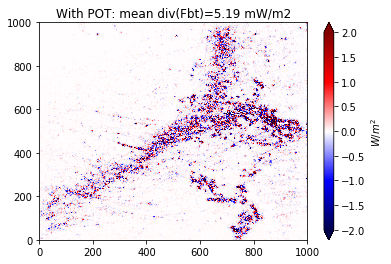

In [72]:
# take luckym2 and luvky-nopot, compute barotropic flux divergence and plot low-pass filtered (i.e. mean)
### Rebuild barotropic fluxes: LUCKYM2, established

it = 5*24
path_2D = krypton+"prov/luckym2-beg_tseries_2Dvars.nc"
Nt = 180
tcut = 20.  # cutoff period for lowpass filter
damp = 2.   # colorbar amplitude

grav = 9.81; rho0 = 1025.
times = np.arange(Nt)/24.

tmes, tmeb = time.clock(), time.time()

nc = Dataset(path_2D, "r")
xi = nc.variables['xi_rho'][:].astype(int)
eta = nc.variables['eta_rho'][:].astype(int)
nc.close()

nc = Dataset(krypton+'lucky_corgrd.nc', "r")
topo = nc.variables['h'][eta,:][:,xi]
dxm = ( (xi[1]-xi[0]) / nc.variables['pm'][eta,:][:,xi] ).mean()
dym = ( (eta[1]-eta[0]) / nc.variables['pn'][eta,:][:,xi] ).mean()
nc.close()
Ny, Nx = topo.shape

bb, aa = sig.butter(4, 2./tcut, btype="low")

print("initialisation took {0:.2f} / {1:.2f}".format(time.clock()-tmes, time.time()-tmeb) )
tmes, tmeb = time.clock(), time.time()

nc = Dataset(path_2D, "r")
pu = np.zeros((Ny,Nx))
pv = np.zeros((Ny,Nx))
for iy in range(Ny):
    pb = nc.variables['pbar'][iy,:,:Nt]
    pb -= np.nanmean(pb, axis=-1)[:,None]
    pb += rho0*grav*nc.variables['zeta'][iy,:,:Nt]
    pu[iy,:] = sig.filtfilt(bb, aa, pb*nc.variables['ubar'][iy,:,:Nt] \
                            , axis=-1, method="gust")[:,it]
    pv[iy,:] = sig.filtfilt(bb, aa, pb*nc.variables['vbar'][iy,:,:Nt] \
                            , axis=-1, method="gust")[:,it]
    if (iy+1)%100 == 0:
        print("iy={0:03d}, t = {1:.2f} / {2:.2f}".format(iy, time.clock()-tmes, time.time()-tmeb) )
        tmes, tmeb = time.clock(), time.time()
nc.close()
pua = pu*topo
pva = pv*topo
del pu, pv

divfa = ( np.gradient(pua, dxm, axis=1) + np.gradient(pva, dym, axis=0) )

plt.figure()
plt.pcolormesh(divfa, vmin=-damp, vmax=damp, cmap='seismic')
ac = plt.colorbar(extend="both")
ac.set_label(r'$W/m^2$')

plt.title("With POT: mean div(Fbt)={:.2f} mW/m2".format(np.nanmean(divfa)*1e3) )

if dosavefig:
    plt.savefig(picdir+"luckym2-beg_Fbt_it{:03d}.png".format(it), magnification="auto"\
                , dpi=150, bbox_inches="tight")

initialisation took 0.19 / 2.33
iy=099, t = 12.66 / 6.32
iy=199, t = 11.22 / 3.71
iy=299, t = 10.36 / 2.78
iy=399, t = 11.25 / 3.47
iy=499, t = 10.95 / 12.38
iy=599, t = 11.76 / 4.50
iy=699, t = 10.33 / 2.82
iy=799, t = 11.40 / 4.10
iy=899, t = 10.83 / 3.40
iy=999, t = 10.32 / 2.67


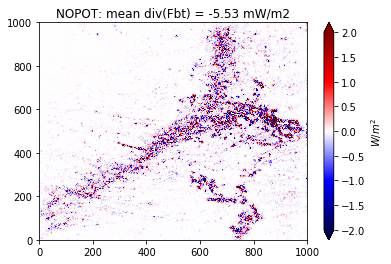

In [73]:
# take luckym2 and luvky-nopot, compute barotropic flux divergence and plot low-pass filtered (i.e. mean)
### Rebuild barotropic fluxes: LUCKYM2, established

it = 5*24
path_2D = krypton+"prov/luckym2-nopot_tseries_2Dvars.nc"
Nt = 180
tcut = 20.  # cutoff period for lowpass filter
damp = 2.   # colorbar amplitude

grav = 9.81; rho0 = 1025.
times = np.arange(Nt)/24.

tmes, tmeb = time.clock(), time.time()

nc = Dataset(path_2D, "r")
xi = nc.variables['xi_rho'][:].astype(int)
eta = nc.variables['eta_rho'][:].astype(int)
nc.close()

nc = Dataset(krypton+'lucky_corgrd.nc', "r")
topo = nc.variables['h'][eta,:][:,xi]
dxm = ( (xi[1]-xi[0]) / nc.variables['pm'][eta,:][:,xi] ).mean()
dym = ( (eta[1]-eta[0]) / nc.variables['pn'][eta,:][:,xi] ).mean()
nc.close()
Ny, Nx = topo.shape

bb, aa = sig.butter(4, 2./tcut, btype="low")

print("initialisation took {0:.2f} / {1:.2f}".format(time.clock()-tmes, time.time()-tmeb) )
tmes, tmeb = time.clock(), time.time()

nc = Dataset(path_2D, "r")
pu = np.zeros((Ny,Nx))
pv = np.zeros((Ny,Nx))
for iy in range(Ny):
    pb = nc.variables['pbar'][iy,:,:Nt]
    pb -= np.nanmean(pb, axis=-1)[:,None]
    pb += rho0*grav*nc.variables['zeta'][iy,:,:Nt]
    pu[iy,:] = sig.filtfilt(bb, aa, pb*nc.variables['ubar'][iy,:,:Nt] \
                            , axis=-1, method="gust")[:,it]
    pv[iy,:] = sig.filtfilt(bb, aa, pb*nc.variables['vbar'][iy,:,:Nt] \
                            , axis=-1, method="gust")[:,it]
    if (iy+1)%100 == 0:
        print("iy={0:03d}, t = {1:.2f} / {2:.2f}".format(iy, time.clock()-tmes, time.time()-tmeb) )
        tmes, tmeb = time.clock(), time.time()
nc.close()
pub = pu*topo
pvb = pv*topo
del pu, pv

divfb = ( np.gradient(pub, dxm, axis=1) + np.gradient(pvb, dym, axis=0) )

plt.figure()
plt.pcolormesh(divfb, vmin=-damp, vmax=damp, cmap='seismic')
ac = plt.colorbar(extend="both")
ac.set_label(r'$W/m^2$')

plt.title( "NOPOT: mean div(Fbt) = {:.2f} mW/m2".format(np.nanmean(divfb)*1e3) )

if dosavefig:
    plt.savefig(picdir+"luckym2-nopot_Fbt_it{:03d}.png".format(it), magnification="auto"\
                , dpi=150, bbox_inches="tight")

mean diff.: 10.72 mW/m^2


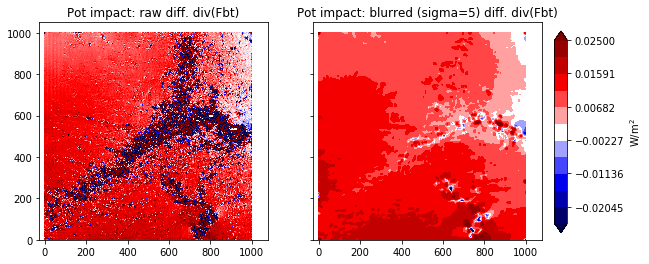

In [74]:
diff = 2.5e-2

levels = np.linspace(-diff,diff,12)

toplot = divfa - divfb

print("mean diff.: {:.2f} mW/m^2".format(np.nanmean(toplot)*1e3))

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9,4))

axs[0].pcolormesh(toplot, vmin=-diff, vmax=diff, cmap="seismic")
toplot = ndi.gaussian_filter(toplot, 5, cval=np.nanmean(toplot))
axs[0].set_title('Pot impact: raw diff. div(Fbt)')
#axs[1].pcolormesh(toplot, vmin=-diff, vmax=diff, cmap="seismic")
hpc = axs[1].contourf(toplot, levels, cmap='seismic', extend="both")
axs[1].set_title('Pot impact: blurred (sigma=5) diff. div(Fbt)')

for ax in axs:
    ax.set_aspect(1)
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
ac = fig.colorbar(hpc, cax=cbar_ax, extend="both")
ac.set_label(r'W/m$^2$')

if dosavefig:
    plt.savefig(picdir+"luckym2_DIFF-Fbt_it{:03d}.png".format(it), magnification="auto"\
                , dpi=150, bbox_inches="tight")

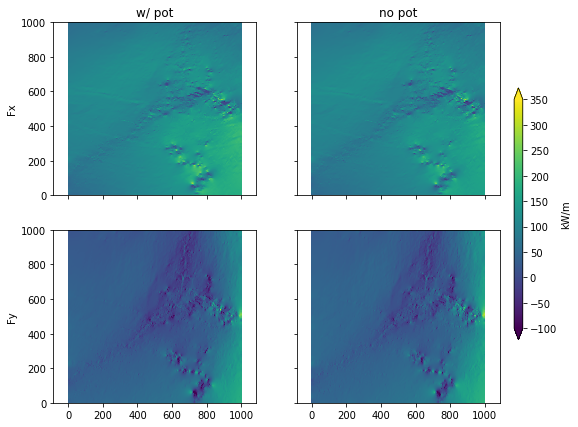

In [75]:
pumi = -100
puma = 350

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8,7))

hpc = axs[0][0].pcolormesh(pua/1e3, vmin=pumi, vmax=puma)
axs[0][1].pcolormesh(pub/1e3, vmin=pumi, vmax=puma)
axs[1][0].pcolormesh(pva/1e3, vmin=pumi, vmax=puma)
axs[1][1].pcolormesh(pvb/1e3, vmin=pumi, vmax=puma)

for ax in axs.ravel():
    ax.set_aspect(1)
axs[0][0].set_title('w/ pot')
axs[0][1].set_title('no pot')
axs[0][0].set_ylabel('Fx')
axs[1][0].set_ylabel('Fy')
    
fig.subplots_adjust(right=0.90)
cbar_ax = fig.add_axes([0.925, 0.25, 0.015, 0.5])
ac = fig.colorbar(hpc, cax=cbar_ax, extend="both")
ac.set_label('kW/m')

if dosavefig:
    plt.savefig(picdir+"luckym2_Fbt-lf_it{:03d}.png".format(it), magnification="auto"\
                , dpi=150, bbox_inches="tight")

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


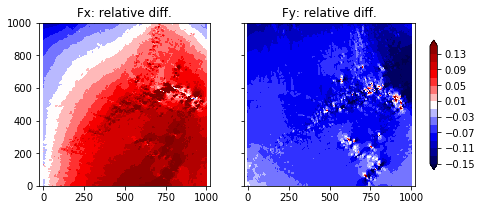

In [76]:
pmod = 0.5*(np.sqrt(pua**2+pva**2) + np.sqrt(pub**2+pvb**2))/1e3
levels = np.arange(-0.15,0.16,0.02)

fig, axs = plt.subplots( 1, 2, sharex=True, sharey=True, figsize=(7,3) )
hpc = axs[0].contourf((pua-pub)/pmod/1e3, levels, cmap='seismic', extend="both")
axs[1].contourf((pva-pvb)/pmod/1e3, levels, cmap='seismic', extend="both")

for ax in axs.ravel():
    ax.set_aspect(1)

axs[0].set_title('Fx: relative diff.')
axs[1].set_title('Fy: relative diff.')

fig.subplots_adjust(right=0.87)
cbar_ax = fig.add_axes([0.9, 0.2, 0.015, 0.6])
fig.colorbar(hpc, cax=cbar_ax, extend="both")

if dosavefig:
    plt.savefig(picdir+"luckym2_Fbt-diff_it{:03d}.png".format(it), magnification="auto"\
                , dpi=150, bbox_inches="tight")

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


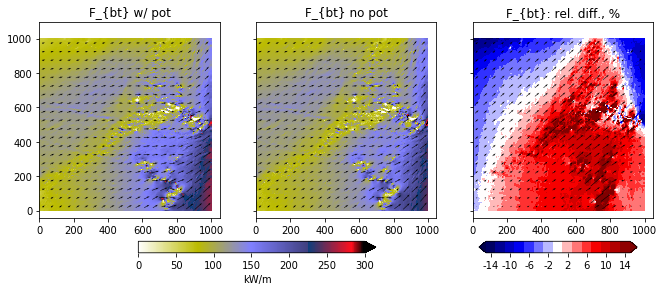

In [62]:
vmax = 300
levels = np.arange(-0.15,0.16,0.02)

pmoda = np.sqrt(pua**2+pva**2)/1e3
pmodb = np.sqrt(pub**2+pvb**2)/1e3
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(11,4))
hpc = axs[0].pcolormesh(pmoda, cmap='gist_stern_r', vmin=0, vmax=vmax)
axs[1].pcolormesh(pmodb, cmap='gist_stern_r', vmin=0, vmax=vmax)
hpd = axs[2].contourf((pmoda - pmodb)/pmod, levels, cmap='seismic', extend="both")

for ax in axs:
    ax.set_aspect(1)
axs[0].set_title('F_{bt} w/ pot')
axs[1].set_title('F_{bt} no pot')
axs[2].set_title('F_{bt}: rel. diff., %')

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.25,0.08,0.3,0.04])
ac = fig.colorbar(hpc, cax=cbar_ax, extend="max", orientation="horizontal")
ac.set_label('kW/m')
cbar_ax = fig.add_axes([0.68,0.08,0.20,0.04])
ac = fig.colorbar(hpd, cax=cbar_ax, extend="both", orientation="horizontal")
ac.set_ticks((levels[:-1]+levels[1:])[::2]/2.)
ac.set_ticklabels([int(round(item*100)) for item in ac.get_ticks()])

# add quiver
nsx = 50
slix = slice(nsx//2, Nx, nsx)
sliy = slice(nsx//2, Ny, nsx)
qk = axs[0].quiver(np.arange(nsx//2, Nx, nsx), np.arange(nsx//2,Ny,nsx) \
                   , pua[sliy,slix]/1e3, pva[sliy,slix]/1e3, pivot="middle", color="k")
axs[1].quiver(np.arange(nsx//2, Nx, nsx), np.arange(nsx//2,Ny,nsx) \
                   , pub[sliy,slix]/1e3, pvb[sliy,slix]/1e3, pivot="middle", color="k")
axs[2].quiver(np.arange(nsx//2, Nx, nsx), np.arange(nsx//2,Ny,nsx) \
                   , (pua-pva)[sliy,slix]/1e3, (pub-pvb)[sliy,slix]/1e3, pivot="middle", color="k")

if dosavefig:
    plt.savefig(picdir+"luckym2_Famp-diff_it{:03d}.png".format(it), magnification="auto"\
                , dpi=150, bbox_inches="tight")

In [91]:
# conversion term -- N.B.: here it's luckym2 vs. lucym2-nopot

nc = MFDataset(krypton+"DIAG/NRJ_fluxes/luckym2-beg_bt_fluxes.?.nc", aggdim="eta_rho")
Cta = nc.variables['Ct_lf'][:,:,it]
nc.close()

nc = MFDataset(krypton+"DIAG/NRJ_fluxes/luckym2-nopot_bt_fluxes.?.nc", aggdim="eta_rho")
Ctb = nc.variables['Ct_lf'][:,:,it]
nc.close()

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


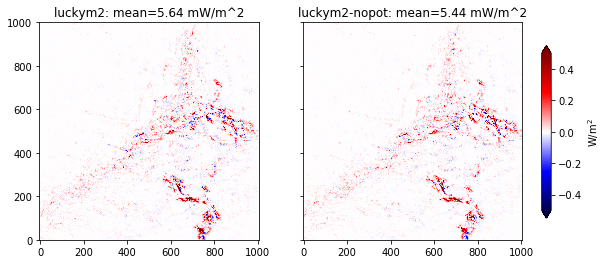

In [92]:
ctamp = 0.5

fig, axs = plt.subplots( 1, 2, sharex=True, sharey=True, figsize=(9,4) )
hpc = axs[0].pcolormesh(Cta, cmap='seismic', vmin=-ctamp, vmax=ctamp)
axs[1].pcolormesh(Ctb, cmap='seismic', vmin=-ctamp, vmax=ctamp)

for ax in axs.ravel():
    ax.set_aspect(1)
    
fig.subplots_adjust(right=0.87)
cbar_ax = fig.add_axes([0.9, 0.2, 0.015, 0.6])
ac = fig.colorbar(hpc, cax=cbar_ax, extend="both")
ac.set_label(r'W/m$^2$')

axs[0].set_title('luckym2: mean={:.2f} mW/m^2'.format(np.nanmean(Cta)*1e3))
axs[1].set_title('luckym2-nopot: mean={:.2f} mW/m^2'.format(np.nanmean(Ctb)*1e3))

if dosavefig:
    plt.savefig(picdir+"luckym2_Ct-lf_it{:03d}.png".format(it), magnification="auto"\
                , dpi=150, bbox_inches="tight")

1137
mean, max = 226.99, 0.20 mW/m^2
19453


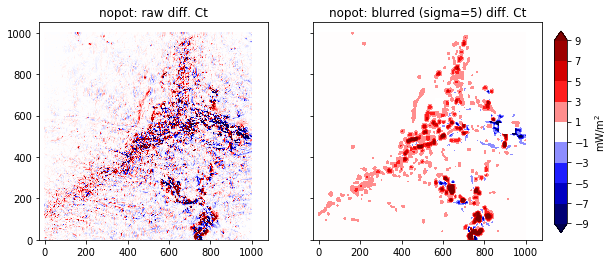

In [95]:
diff = 9.
levels = np.linspace(-diff,diff,10)

toplot = (Cta - Ctb)*1e3

print(np.isnan(toplot).sum())
print('mean, max = {0:.2f}, {1:.2f} mW/m^2'.format(np.nanmax(toplot),np.nanmean(toplot)))

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9,4))

axs[0].pcolormesh(toplot, vmin=-diff, vmax=diff, cmap="seismic")
axs[0].set_title('nopot: raw diff. Ct')

toplot = ndi.gaussian_filter(toplot, 5, cval=np.nanmean(toplot))
hpc =  axs[1].contourf(toplot, levels, cmap="seismic", extend="both")
axs[1].set_title('nopot: blurred (sigma=5) diff. Ct')

print(np.isnan(toplot).sum())

for ax in axs:
    ax.set_aspect(1)
    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
ac = fig.colorbar(hpc, cax=cbar_ax, extend="both")
ac.set_label(r'mW/m$^2$')

if dosavefig:
    plt.savefig(picdir+"luckym2_Ct-diff_it{:03d}.png".format(it), magnification="auto"\
                , dpi=150, bbox_inches="tight")

In [80]:
# Kinetic and potential energy: maps at given time
nc = MFDataset(krypton+"DIAG/NRJ_fluxes/luckym2-beg_bt_fluxes.?.nc", aggdim="eta_rho")
kea = nc.variables['ekbt_lf'][:,:,it]
pea = nc.variables['epbt_lf'][:,:,it]
nc.close()

nc = MFDataset(krypton+"DIAG/NRJ_fluxes/luckym2-nopot_bt_fluxes.?.nc", aggdim="eta_rho")
keb = nc.variables['ekbt_lf'][:,:,it]
peb = nc.variables['epbt_lf'][:,:,it]
nc.close()

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


STD KE=0.04, PE=0.10


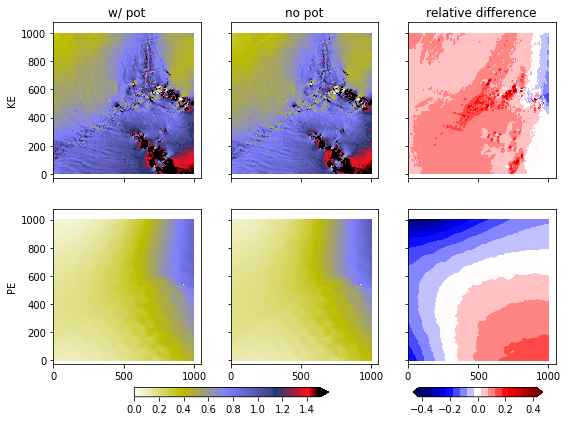

In [89]:
eamp = 1.5
levels = np.arange(-.425, .45 , .05)

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(9,6.5))
hpc = axs[0][0].pcolormesh(kea, vmin=0, vmax=eamp, cmap="gist_stern_r")
axs[0][1].pcolormesh(keb, vmin=0, vmax=eamp, cmap="gist_stern_r")
hpd = axs[0][2].contourf((kea-keb)/kea, levels, cmap="seismic" , extend="both")

axs[1][0].pcolormesh(pea, vmin=0, vmax=eamp, cmap="gist_stern_r")
axs[1][1].pcolormesh(peb, vmin=0, vmax=eamp, cmap="gist_stern_r")
axs[1][2].contourf((pea-peb)/pea, levels, cmap="seismic")

for ax in axs.ravel():
    ax.set_aspect(1)
    
axs[0][0].set_title('w/ pot')
axs[0][1].set_title('no pot')
axs[0][2].set_title('relative difference')
axs[0][0].set_ylabel("KE")
axs[1][0].set_ylabel("PE")

fig.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.25,0.08,0.3,0.02])
fig.colorbar(hpc, cax=cbar_ax, extend="max", orientation="horizontal")
cbar_ax = fig.add_axes([0.68,0.08,0.20,0.02])
ac = fig.colorbar(hpd, cax=cbar_ax, extend="both", orientation="horizontal")
ac.set_ticks([-.4,-.2,0,.2,.4])

print("STD KE={0:.2f}, PE={1:.2f}".format(np.nanstd((kea-keb)/kea),np.nanstd((pea-peb)/pea) ))

if dosavefig:
    plt.savefig(picdir+"luckym2_NRJ-diff_it{:03d}.png".format(it), magnification="auto"\
                , dpi=150, bbox_inches="tight")

In [43]:
# kinetic and potential energy: time evolution
nc = Dataset(krypton+"prov/luckym2-beg_tseries_2Dvars.nc", "r")
kema, pema = np.zeros(Nt), np.zeros(Nt)
for iy in range(Ny):
    kema += np.nanmean( ( nc.variables['ubar'][iy,:,:Nt]**2 \
                        + nc.variables['vbar'][iy,:,:Nt]**2 ) * topo[iy,:,None], axis=0 )/Ny
    pema += np.nanmean( nc.variables['zeta'][iy,:,:Nt]**2, axis=0 )/Ny
nc.close()
kema *= rho0/2.
pema *= rho0*grav/2.

nc = Dataset(krypton+"prov/luckym2-nopot_tseries_2Dvars.nc", "r")
kemb, pemb = np.zeros(Nt), np.zeros(Nt)
for iy in range(Ny):
    kemb += np.nanmean( ( nc.variables['ubar'][iy,:,:Nt]**2 \
                        + nc.variables['vbar'][iy,:,:Nt]**2 ) * topo[iy,:,None], axis=0 )/Ny
    pemb += np.nanmean( nc.variables['zeta'][iy,:,:Nt]**2, axis=0 )/Ny
nc.close()
kemb *= rho0/2.
pemb *= rho0*grav/2.

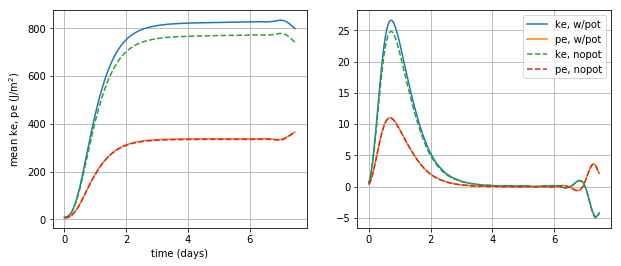

In [46]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(10,4))

prov = sig.filtfilt(bb, aa, kema, method="gust")
axs[0].plot(times, prov)
axs[1].plot(times, np.gradient(prov))

prov = sig.filtfilt(bb, aa, pema, method="gust")
axs[0].plot(times, prov)
axs[1].plot(times, np.gradient(prov))

prov = sig.filtfilt(bb, aa, kemb, method="gust")
axs[0].plot(times, prov, '--')
axs[1].plot(times, np.gradient(prov), '--')

prov = sig.filtfilt(bb, aa, pemb, method="gust")
axs[0].plot(times, prov, '--')
axs[1].plot(times, np.gradient(prov), '--')

plt.legend(['ke, w/pot', 'pe, w/pot', 'ke, nopot', 'pe, nopot'])
axs[0].set_ylabel(r'mean ke, pe (J/m$^2$)')
axs[0].set_xlabel('time (days)')

for ax in axs:
    ax.grid(True)
    
if dosavefig:
    plt.savefig(picdir+"luckym2_NRJ-diff_evol.pdf", magnification="auto"\
                , dpi=150, bbox_inches="tight")

In [51]:
wh2mw = 1000/3600.
print( \
      np.gradient(sig.filtfilt(bb, aa, kema, method="gust"))[5*24]*wh2mw\
        , np.gradient(sig.filtfilt(bb, aa, kemb, method="gust"))[5*24]*wh2mw\
        , np.gradient(sig.filtfilt(bb, aa, pema, method="gust"))[5*24]*wh2mw\
        , np.gradient(sig.filtfilt(bb, aa, pemb, method="gust"))[5*24]*wh2mw, rho0 )

0.0348661290962 0.0330487674702 -0.000115206526077 -0.00062520300165 1025.0


In [77]:
# tidal potential: compute its amplitude based on ubar, vbar in simulations
it = 5*24
dx, dy = 748.26, 748.27
tcut = 20.

bb, aa = sig.butter(4, 2./tcut, btype="low")

path_2D = krypton+"prov/luckym2-beg_tseries_2Dvars.nc"
Nt = 180

# load tidal potential from LUCKY's forcing file
ncfrc = Dataset('/net/ruchba/local/tmp/2/lahaye/prep_LUCKYTO/luckym2_frc.nc')
potamp = ncfrc.variables['tide_Pamp'][0,:,:]
potpha = np.deg2rad(ncfrc.variables['tide_Pphase'][0,:,:])
period = ncfrc.variables['tide_period'][0] # hours
ncfrc.close()
dpamp_dx = np.gradient(potamp, dx, axis=-1)[:,xi][eta,:]
dpamp_dy = np.gradient(potamp, dy, axis=-2)[:,xi][eta,:]
dphat_dx = np.gradient(potpha, dx, axis=-1)[:,xi][eta,:]
dphat_dy = np.gradient(potpha, dy, axis=-2)[:,xi][eta,:]
potamp = potamp[:,xi][eta,:]
potpha = potpha[:,xi][eta,:]

nc = Dataset(path_2D, "r")
times = nc.variables['scrum_time'][:Nt] # hours

fpot = np.zeros(topo.shape)
for iy in range(Ny):
    theta = 2*np.pi*times[None,:]/period - potpha[iy,:,None]
    fpot[iy,:] = sig.filtfilt(bb, aa, nc.variables['ubar'][iy,:,:Nt]*( \
                    dpamp_dx[iy,:,None]*np.cos(theta) + potamp[iy,:,None]\
                    *dphat_dx[iy,:,None]*np.sin(theta) ), method="gust", axis=-1)[:,it]
    fpot[iy,:] += sig.filtfilt(bb, aa, nc.variables['vbar'][iy,:,:Nt]*( \
                    dpamp_dy[iy,:,None]*np.cos(theta) + potamp[iy,:,None]\
                    *dphat_dy[iy,:,None]*np.sin(theta) ), method="gust", axis=-1)[:,it] 
nc.close()
fpot *= topo*rho0*grav*1e3    # mW/m²

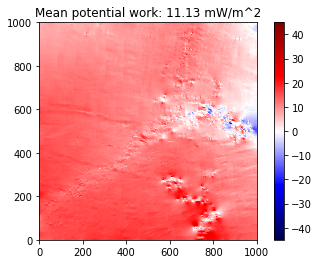

In [78]:
# plot potential work
plt.figure()
plt.pcolormesh(fpot, cmap='seismic', vmin=-45, vmax=45)
plt.colorbar()
plt.gca().set_aspect(1)
plt.title("Mean potential work: {:.2f} mW/m^2".format(np.nanmean(fpot)))

if dosavefig:
    plt.savefig(picdir+"luckym2-beg_TidPotWork_it{:03d}.png".format(it), magnification="auto"\
                , dpi=150, bbox_inches="tight")